<a href="https://colab.research.google.com/github/saraires/Proyecto-Modelos1/blob/main/03_preparaci%C3%B3n_de_datos_y_entrenamiento_de_la_Red_Neuronal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **03 - Preparación de Datos y Entrenamiento de la Red Neuronal**
### Santiago Palacio Cárdenas
### Sarai Restrepo Rodríguez
### Natalia Bernal Gutiérrez

En este notebook se desarrolla un proceso completo para la preparación, transformación y modelado de los datos asociados al rendimiento académico estudiantil. El objetivo principal es construir un pipeline reproducible que tome los datos originales, los limpie utilizando reglas coherentes con el contexto educativo y posteriormente entrene una red neuronal capaz de clasificar el rendimiento global de los estudiantes. Todo el flujo se organiza de forma modular, asegurando que cada etapa desde la limpieza hasta el entrenamiento pueda reutilizarse sin ajustes adicionales.

Además, este notebook complementa el trabajo realizado en entregas previas al integrar un modelo de Deep Learning que permite explorar una estrategia diferente de predicción. A través de una ingeniería de datos optimizada, codificación categórica, normalización y ajustes del modelo, se construye una solución más robusta para generar predicciones consistentes tanto en los datos de entrenamiento como en los datos de envío para Kaggle.

# **1. Extrayendo Información desde Kaggle**

En esta sección se realiza la carga de los datos necesarios para construir el modelo. Los archivos se obtienen directamente desde la plataforma Kaggle, donde se encuentran disponibles como parte de la competencia. Una vez descargados, se incorporan al entorno de trabajo para poder explorarlos, verificar su estructura y prepararlos para el proceso de limpieza y transformación. Este paso inicial es fundamental, ya que garantiza que el resto del pipeline funcione sobre datos consistentes y correctamente estructurados.


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.65GB/s]


In [ ]:
!unzip udea*.zip > /dev/null
!wc *.csv

   296787    296787   4716673 submission_example.csv
   296787   4565553  59185238 test.csv
   692501  10666231 143732437 train.csv
  1286075  15528571 207634348 total


# **2.Importación de Librerías**

En esta sección se importan todas las librerías necesarias para el flujo completo del proyecto, incluyendo manipulación de datos, transformación de variables, normalización y construcción del modelo neuronal. Se integran herramientas de *pandas* y *numpy* para el manejo de estructuras tabulares, *scikit-learn* para preprocesamiento y partición del dataset, y *TensorFlow* para la creación y entrenamiento de la red neuronal. Esta configuración inicial garantiza que todas las operaciones posteriores puedan ejecutarse correctamente y de manera eficiente dentro del notebook.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


# **3. Preprocesamiento Avanzado de Datos según Lineamientos de la Segunda Entrega**

En esta sección se implementa el proceso de limpieza y transformación de datos correspondiente a la segunda entrega del proyecto. Aquí se estandarizan categorías, se imputan valores faltantes usando moda o reglas específicas, se aplican codificaciones *frequency*, *label* y *ordinal*, y se reorganizan columnas como *PERIODO* para obtener variables derivadas más útiles como **AÑO** y **BIMESTRE**. Además, se depuran variables incompatibles o duplicadas y se ajusta el objetivo (*RENDIMIENTO_GLOBAL*) a un formato numérico adecuado para el modelo neuronal. El resultado es un dataset totalmente numérico, consistente y preparado para el entrenamiento del modelo.


In [ ]:
# ------------------------------------------------------------
# LIMPIEZA: PERIODO_ACADEMICO  →  AÑO y PERIODO
# ------------------------------------------------------------
def clean_periodo(df):
    df["AÑO"] = df["PERIODO_ACADEMICO"].astype(str).str[:4].astype(int)
    df["PERIODO"] = df["PERIODO_ACADEMICO"].astype(str).str[4].astype(int)
    df.drop(columns=["PERIODO_ACADEMICO"], inplace=True)


# ------------------------------------------------------------
# LIMPIEZA: E_PRGM_ACADEMICO  (FREQ ENCODING)
# ------------------------------------------------------------
def clean_programa_academico(df):
    freq = df["E_PRGM_ACADEMICO"].value_counts(normalize=True)
    df["E_PRGM_ACADEMICO"] = df["E_PRGM_ACADEMICO"].map(freq)


# ------------------------------------------------------------
# LIMPIEZA: E_PRGM_DEPARTAMENTO  (FREQ ENCODING)
# ------------------------------------------------------------
def clean_departamento(df):
    freq = df["E_PRGM_DEPARTAMENTO"].value_counts(normalize=True)
    df["E_PRGM_DEPARTAMENTO"] = df["E_PRGM_DEPARTAMENTO"].map(freq)


# ------------------------------------------------------------
# LIMPIEZA: E_VALORMATRICULAUNIVERSIDAD  (MAPEO NUMÉRICO)
# ------------------------------------------------------------
def clean_matricula(df):

    mapping = {
        "Entre 5.5 millones y menos de 7 millones": 6,
        "Entre 4 millones y menos de 5.5 millones": 5,
        "Entre 2.5 millones y menos de 4 millones": 3,
        "Más de 7 millones": 7,
        "Entre 1 millón y menos de 2.5 millones": 2,
        "Entre 500 mil y menos de 1 millón": 1,
        "Menos de 500 mil": 1,
        "No pagó matrícula": 0
    }

    df["E_VALORMATRICULAUNIVERSIDAD"] = df["E_VALORMATRICULAUNIVERSIDAD"].map(mapping)
    df["E_VALORMATRICULAUNIVERSIDAD"].fillna(df["E_VALORMATRICULAUNIVERSIDAD"].mode()[0], inplace=True)


# ------------------------------------------------------------
# LIMPIEZA: E_HORASSEMANATRABAJA (MAPEO NUMÉRICO)
# ------------------------------------------------------------
def clean_horas_trabajo(df):

    mapping = {
        "Menos de 10 horas": 5,
        "0": 0,
        "Más de 30 horas": 35,
        "Entre 21 y 30 horas": 25.5,
        "Entre 11 y 20 horas": 15.5
    }

    df["E_HORASSEMANATRABAJA"] = df["E_HORASSEMANATRABAJA"].map(mapping)
    df["E_HORASSEMANATRABAJA"].fillna(df["E_HORASSEMANATRABAJA"].mode()[0], inplace=True)


# ------------------------------------------------------------
# LIMPIEZA: F_ESTRATOVIVIENDA (ORDINAL)
# ------------------------------------------------------------
def clean_estrato(df):

    orden = [
        "Sin Estrato",
        "Estrato 1",
        "Estrato 2",
        "Estrato 3",
        "Estrato 4",
        "Estrato 5",
        "Estrato 6"
    ]

    df["F_ESTRATOVIVIENDA"].fillna("Sin Estrato", inplace=True)
    encoder = OrdinalEncoder(categories=[orden])
    df["F_ESTRATOVIVIENDA"] = encoder.fit_transform(df[["F_ESTRATOVIVIENDA"]]).astype(int)


# ------------------------------------------------------------
# LIMPIEZA: F_TIENEINTERNET (BINARIO)
# ------------------------------------------------------------
def clean_internet(df):
    df["F_TIENEINTERNET"].fillna("Si", inplace=True)
    df["F_TIENEINTERNET"] = df["F_TIENEINTERNET"].map({"Si": 1, "No": 0})


# ------------------------------------------------------------
# LIMPIEZA: F_EDUCACIONPADRE (ORDINAL)
# ------------------------------------------------------------
def clean_padre(df):
    df["F_EDUCACIONPADRE"].fillna("Sin Información", inplace=True)
    df["F_EDUCACIONPADRE"].replace(
        {"No sabe": "Sin Información", "No Aplica": "Sin Información", "Ninguno": "Sin Información"},
        inplace=True
    )

    niveles = [
        "Sin Información",
        "Primaria incompleta",
        "Técnica o tecnológica incompleta",
        "Educación profesional incompleta",
        "Técnica o tecnológica completa",
        "Secundaria (Bachillerato) incompleta",
        "Primaria completa",
        "Secundaria (Bachillerato) completa",
        "Educación profesional completa",
        "Postgrado"
    ]

    encoder = OrdinalEncoder(categories=[niveles])
    df["F_EDUCACIONPADRE"] = encoder.fit_transform(df[["F_EDUCACIONPADRE"]]).astype(int)


# ------------------------------------------------------------
# LIMPIEZA: F_EDUCACIONMADRE (ORDINAL)
# ------------------------------------------------------------
def clean_madre(df):
    df["F_EDUCACIONMADRE"].fillna("Sin Información", inplace=True)
    df["F_EDUCACIONMADRE"].replace(
        {"No sabe": "Sin Información", "No Aplica": "Sin Información", "Ninguno": "Sin Información"},
        inplace=True
    )

    niveles = [
        "Sin Información",
        "Primaria incompleta",
        "Técnica o tecnológica incompleta",
        "Educación profesional incompleta",
        "Técnica o tecnológica completa",
        "Secundaria (Bachillerato) incompleta",
        "Primaria completa",
        "Secundaria (Bachillerato) completa",
        "Educación profesional completa",
        "Postgrado"
    ]

    encoder = OrdinalEncoder(categories=[niveles])
    df["F_EDUCACIONMADRE"] = encoder.fit_transform(df[["F_EDUCACIONMADRE"]]).astype(int)


# ------------------------------------------------------------
# LIMPIEZA: VARIABLES BINARIAS
# ------------------------------------------------------------
def clean_binarias(df):

    bin_cols = {
        "F_TIENELAVADORA": {"Si": 1, "No": 0},
        "F_TIENEAUTOMOVIL": {"Si": 1, "No": 0},
        "E_PRIVADO_LIBERTAD": {"S": 1, "N": 0},
        "E_PAGOMATRICULAPROPIO": {"Si": 1, "No": 0},
        "F_TIENECOMPUTADOR": {"Si": 1, "No": 0},
    }

    for col, mapping in bin_cols.items():
        df[col].fillna(df[col].mode()[0], inplace=True)
        df[col] = df[col].map(mapping)


# ------------------------------------------------------------
# LIMPIEZA DE COLUMNA DUPLICADA
# ------------------------------------------------------------
def clean_duplicate_internet(df):
    if "F_TIENEINTERNET.1" in df.columns:
        df.drop(columns=["F_TIENEINTERNET.1"], inplace=True)


# ------------------------------------------------------------
# LIMPIEZA: TARGET
# ------------------------------------------------------------
def clean_target(df):
    mapping = {
        "bajo": 0,
        "medio-bajo": 1,
        "medio-alto": 2,
        "alto": 3
    }
    df["RENDIMIENTO_GLOBAL"] = df["RENDIMIENTO_GLOBAL"].map(mapping)




In [ ]:
# ------------------------------------------------------------
# FUNCIÓN PRINCIPAL DE CLEANING
# ------------------------------------------------------------
def data_cleaning(df):

    df = df.copy()

    clean_periodo(df)
    clean_programa_academico(df)
    clean_departamento(df)
    clean_matricula(df)
    clean_horas_trabajo(df)
    clean_estrato(df)
    clean_internet(df)
    clean_padre(df)
    clean_madre(df)
    clean_binarias(df)
    clean_duplicate_internet(df)

    if "RENDIMIENTO_GLOBAL" in df.columns:
        clean_target(df)

    # Eliminar ID, no sirve para aprendizaje
    if "ID" in df.columns:
        df.drop(columns=["ID"], inplace=True)

    return df

In [ ]:
# ==================================================
# EJECUCIÓN DEL CLEANING SOBRE TRAIN
# ==================================================
data = pd.read_csv("train.csv")
data_fixed = data_cleaning(data)
data_fixed.head()

/tmp/ipython-input-2948742242.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["E_VALORMATRICULAUNIVERSIDAD"].fillna(df["E_VALORMATRICULAUNIVERSIDAD"].mode()[0], inplace=True)
/tmp/ipython-input-2948742242.py:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4,AÑO,PERIODO
0,0.016801,0.407450,6.0,5.0,3,1,2,1,1,0,0,1,9,2,0.322,0.208,0.310,0.267,2021,2
1,0.076887,0.059235,3.0,0.0,3,0,4,1,0,0,0,1,2,0,0.311,0.215,0.292,0.264,2021,2
2,0.002465,0.407450,3.0,35.0,3,1,7,1,0,0,0,0,7,0,0.297,0.214,0.305,0.264,2020,3
3,0.074949,0.041629,5.0,0.0,4,1,0,1,0,0,0,1,7,3,0.485,0.172,0.252,0.190,2019,5
4,0.046111,0.120732,3.0,25.5,3,1,6,1,1,0,0,1,6,1,0.316,0.232,0.285,0.294,2021,2


# **4. Construcción del Modelo Neuronal**

En esta parte se implementa la clase responsable de crear, entrenar y evaluar la red neuronal diseñada para predecir el desempeño académico. La clase organiza todo el flujo del modelo: prepara los datos normalizados, define una arquitectura densa con capas ocultas optimizadas, incorpora mecanismos de regularización como *dropout* y utiliza *Early Stopping* para evitar sobreajuste. También incluye funciones para visualizar las curvas de entrenamiento y para almacenar el modelo final. Con esta clase, el proceso de modelado queda completamente automatizado, estructurado y reutilizable para cualquier conjunto de datos ya limpiado con el preprocesamiento anterior.


In [ ]:
class StudentNNClassifier:

    def __init__(self, epochs=50, batch_size=32, lr=0.001):
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.model = None
        self.scaler = None
        self.feature_names = None
        self.history = None


    # ============================================================
    # PREPARACIÓN DE DATOS
    # ============================================================
    def prepare_data(self, df_clean, target_col="RENDIMIENTO_GLOBAL", test_size=0.2):

        # Guardar nombres de columnas para usar en test.csv
        self.feature_names = [col for col in df_clean.columns if col != target_col]

        X = df_clean[self.feature_names].values
        y = df_clean[target_col].values

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        # Normalización
        self.scaler = MinMaxScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_test = self.scaler.transform(X_test)

        return X_train, X_test, y_train, y_test


    # ============================================================
    # CREACIÓN DEL MODELO
    # ============================================================
    def build_model(self, input_dim, num_classes):

        model = models.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.25),

            layers.Dense(32, activation='relu'),
            layers.Dropout(0.25),

            layers.Dense(num_classes, activation='softmax')
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.lr),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

        return model


    # ============================================================
    # ENTRENAMIENTO + EVALUACIÓN
    # ============================================================
    def train_and_evaluate(self, model, X_train, X_test, y_train, y_test):

        early_stop = EarlyStopping(
            monitor="val_loss",
            patience=6,
            restore_best_weights=True
        )

        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=1,
            callbacks=[early_stop]
        )

        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        print(f"\n🔹 Exactitud en Test: {acc:.4f}")

        self.history = history
        return history


    # ============================================================
    # VISUALIZACIÓN DEL ENTRENAMIENTO
    # ============================================================
    def plot_training(self):
        history = self.history
        plt.figure(figsize=(14, 5))

        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history["accuracy"], label="Entrenamiento")
        plt.plot(history.history["val_accuracy"], label="Validación")
        plt.title("Precisión")
        plt.xlabel("Épocas")
        plt.ylabel("Accuracy")
        plt.legend()

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history["loss"], label="Entrenamiento")
        plt.plot(history.history["val_loss"], label="Validación")
        plt.title("Pérdida")
        plt.xlabel("Épocas")
        plt.ylabel("Loss")
        plt.legend()

        plt.show()


    # ============================================================
    # FLUJO COMPLETO
    # ============================================================
    def run(self, df_clean):

        print("Preparando datos...")
        X_train, X_test, y_train, y_test = self.prepare_data(df_clean)

        print("Construyendo modelo neuronal...")
        num_classes = len(np.unique(y_train))
        model = self.build_model(X_train.shape[1], num_classes)

        print("Entrenando modelo...")
        history = self.train_and_evaluate(model, X_train, X_test, y_train, y_test)

        print("Visualizando resultados...")
        self.plot_training()

        self.model = model
        print("Modelo neuronal listo")

        return model



# **5. Uso del Modelo Entrenado**

Este apartado muestra cómo poner en marcha la clase definida previamente para entrenar la red neuronal, aplicarla sobre los datos procesados y generar las gráficas que permiten observar su rendimiento. Aquí simplemente se ejecuta el flujo completo del modelo de forma organizada y reproducible.


In [ ]:
# Cargar y limpiar
data = pd.read_csv("train.csv")
df_clean = data_cleaning(data)

/tmp/ipython-input-2948742242.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["E_VALORMATRICULAUNIVERSIDAD"].fillna(df["E_VALORMATRICULAUNIVERSIDAD"].mode()[0], inplace=True)
/tmp/ipython-input-2948742242.py:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

In [ ]:
# Crear modelo
nn_model = StudentNNClassifier(epochs=25, batch_size=64, lr=0.001)

Preparando datos...
Construyendo modelo neuronal...
Entrenando modelo...
Epoch 1/25
6925/6925 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.3550 - loss: 1.3169 - val_accuracy: 0.3867 - val_loss: 1.2781
Epoch 2/25
6925/6925 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.3840 - loss: 1.2847 - val_accuracy: 0.3897 - val_loss: 1.2739
Epoch 3/25
6925/6925 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.3863 - loss: 1.2800 - val_accuracy: 0.3899 - val_loss: 1.2730
Epoch 4/25
6925/6925 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.3884 - loss: 1.2784 - val_accuracy: 0.3914 - val_loss: 1.2701
Epoch 5/25
6925/6925 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.3893 - loss: 1.2766 - val_accuracy: 0.3923 - val_loss: 1.2681
Epoch 6/25
6925/6925 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.3914 - loss: 1.2751 - val_accuracy: 0.3920 - val_loss: 1.2677
Epoch 7/25
6925/6925 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.3889 - loss: 1.2753 - val_accuracy: 0.3905 - val_loss: 1.2705
Epoch 8/25

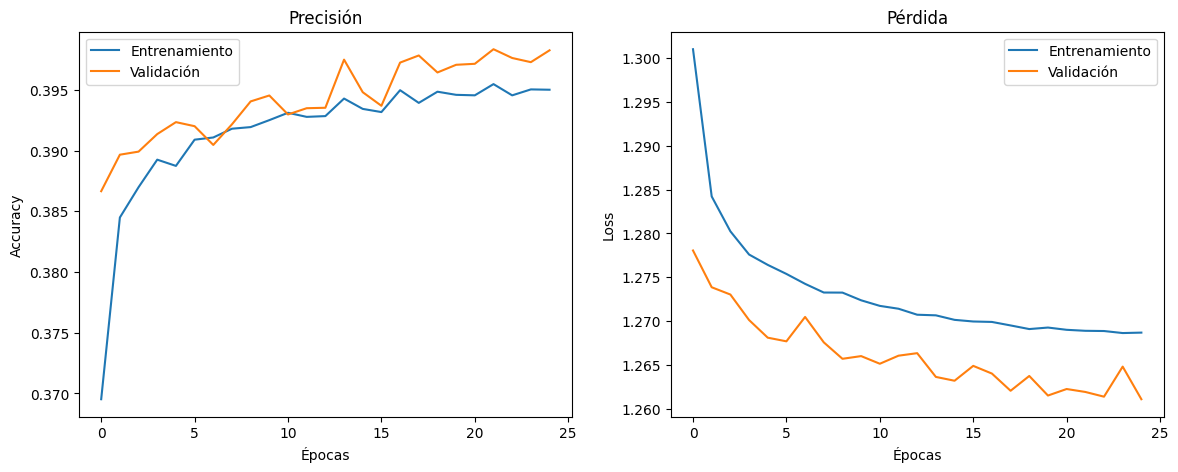

Modelo neuronal listo


<Sequential name=sequential, built=True>

In [ ]:
# Ejecutar entrenamiento
nn_model.run(df_clean)


El análisis de las gráficas evidencia un comportamiento estable del entrenamiento: la precisión aumenta de manera gradual tanto en entrenamiento como en validación, mientras que la pérdida desciende de forma consistente. Esto indica que el modelo logra aprender patrones relevantes sin síntomas claros de sobreajuste. Aunque la exactitud global se mantiene en niveles moderados, las curvas reflejan un aprendizaje controlado y un ajuste adecuado a la complejidad del problema, validando que la arquitectura y el preprocesamiento implementados son funcionales para esta tarea.

# **6. Evaluación con Datos de Envío**

En esta sección se aplica el modelo entrenado sobre el conjunto de datos destinado al envío final en Kaggle. Primero, los datos pasan por el mismo proceso de limpieza que se utilizó durante el entrenamiento para garantizar coherencia entre las características. Luego, el modelo genera las predicciones y estas se transforman nuevamente a sus etiquetas originales, preparando así un archivo final listo para ser cargado en la plataforma. Esta etapa confirma que todo el flujo —preprocesamiento, normalización y modelado— funciona correctamente también sobre datos nunca antes vistos.


In [ ]:
# Cargar test
X = pd.read_csv("test.csv")
X_clean = data_cleaning(X)

/tmp/ipython-input-2948742242.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["E_VALORMATRICULAUNIVERSIDAD"].fillna(df["E_VALORMATRICULAUNIVERSIDAD"].mode()[0], inplace=True)
/tmp/ipython-input-2948742242.py:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

In [ ]:
# Alinear columnas exactas
X_clean = X_clean[nn_model.feature_names]

In [ ]:
# Escalar igual que el train
X_scaled = nn_model.scaler.transform(X_clean)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [ ]:
# Predicción
result = nn_model.model.predict(X_scaled)

class_mapping = {0: 'bajo', 1: 'medio-bajo', 2: 'medio-alto', 3: 'alto'}
pred = np.argmax(result, axis=1)
pred = [class_mapping[p] for p in pred]

predictions = pd.DataFrame({
    "ID": X["ID"],
    "RENDIMIENTO_GLOBAL": pred
})

9275/9275 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


In [ ]:
predictions

,ID,RENDIMIENTO_GLOBAL
0,550236,alto
1,98545,medio-bajo
2,499179,alto
3,782980,bajo
4,785185,bajo
...,...,...
296781,496981,medio-bajo
296782,209415,alto
296783,239074,medio-alto
296784,963852,alto
